In [1]:
import csv 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
import glob
import re

# Load data

## Groud Truth by offline Yolo

In [2]:
def loadData(max_num_bbox,max_num_class,bboxFile,classFile):
    """load data from csv file

    Args:
        max_num_bbox (int): max number of bboxes
        max_num_class (int): max number of classes
        bboxFile (string):bbox file name
        classFile (string): class file name

    Returns:
        dataBbox, dataClass(list) : bbox and class data
    """
    # make column header
    unitColumn = ["frameIndex","left","top","width","height"]*max_num_bbox
    unitColumnClass = ["frameIndex","label"]*max_num_class
    col_namesBbox = [ "{i}-{name}".format(i=i,name=unitColumn[i]) for i in range(len(unitColumn)) ]
    col_namesClass = [ "{i}-{name}".format(i=i,name=unitColumnClass[i]) for i in range(len(unitColumnClass)) ]
    dfBbox = pd.read_csv(filepath_or_buffer=bboxFile,names=col_namesBbox)
    dfBbox = dfBbox.fillna(-2) # fill none in dataFrame with -1
    dfClass = pd.read_csv(filepath_or_buffer=classFile,names=col_namesClass)
    dfClass = dfClass.fillna(-2)
    dataBbox = dfBbox.values
    dataClass = dfClass.values
    dfClass[:3]
    return dataBbox, dataClass

In [3]:
#rootDir = r"C:\Users\kawaw\data_Tracking\objectTracking\yolotestmp4\4objects"
rootDir = r"C:\Users\kawaw\cpp\objectTracking_2cams_v1\objectTracking_2cams_v1"
bboxFile_left = os.path.join(rootDir,"yolo_bbox_2objects_close_left_gt.csv")
bboxFile_right = os.path.join(rootDir,"yolo_bbox_2objects_close_right_gt.csv")
classFile_left = os.path.join(rootDir,"yolo_class_2objects_close_left_gt.csv")
classFile_right = os.path.join(rootDir,"yolo_class_2objects_close_right_gt.csv")
num_bbox_left = 4
num_class_left = 266
num_bbox_right = 2
num_class_right = 10

bbox_gt_left,class_gt_left = loadData(max_num_bbox=num_bbox_left,max_num_class=num_class_left,bboxFile=bboxFile_left,classFile=classFile_left)
bbox_gt_right,class_gt_right = loadData(max_num_bbox=num_bbox_right,max_num_class=num_class_right,bboxFile=bboxFile_right,classFile=classFile_right)

In [4]:
print(bbox_gt_left.shape, class_gt_left.shape)

(241, 20) (241, 532)


## plot data

# draw bboxes in images and make a video

In [5]:
WIDTH=640
HEIGHT=640
COLOR_GT=[255,255,255]

In [6]:
def drawRectangle(data,frame,width=WIDTH,height=HEIGHT,color=COLOR_GT):
    cv2.rectangle(frame,(min(max(int(data[1]),0),width),min(max(int(data[2]),0),height)),(max(min(int(data[1]+data[3]),width),0),max(min(int(data[2]+data[4]),height),0)),thickness=2,color=color)

def editVideo(data,videoPath,saveImgDir):
    latestData = np.zeros(data.shape[1]) #get data
    cap = cv2.VideoCapture(videoPath)

    # Check if the video file opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Create the output folder if it doesn't exist
    if not os.path.exists(saveImgDir):
        os.makedirs(saveImgDir)

    # Get the frames per second (fps) and frame dimensions
    #fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Start reading and saving frames
    counter = 1
    while True:
        print(counter)
        ret, frame = cap.read()

        if not ret:
            break
        # frame is in data
        if counter in data[:,0]:
            indexes = np.where(data[:,0]==counter)[0]
            if (len(indexes)>=2):
                index = indexes[-1]
            else:
                index = indexes[0]
            latestData = data[index]
        #latestData exists
        if latestData[0] != 0:
            iteration_bbox = 0
            while (iteration_bbox< latestData.shape[0]//5):
                if (latestData[5*iteration_bbox]<0):
                    break
                drawRectangle(latestData[5*iteration_bbox:5*(iteration_bbox+1)],frame,width=WIDTH,height=HEIGHT,color=COLOR_GT)
                iteration_bbox += 1
        
        # Save the frame as an image
        frame_filename = os.path.join(saveImgDir, f"{counter:03d}.png")
        cv2.imwrite(frame_filename, frame)

        counter += 1
    # Release the video capture object
    cap.release()

#make video
def atoi(text):
        return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def makeVideo(srcDir,videoFps,outputVideoName):
        img_array=[]
        for filename in sorted(glob.glob(f"{srcDir}/*.png"), key=natural_keys):
            img = cv2.imread(filename)
            height, width, layers = img.shape
            size = (width, height)
            img_array.append(img)

        out = cv2.VideoWriter(outputVideoName, cv2.VideoWriter_fourcc(*'mp4v'), videoFps, size)

        for i in range(len(img_array)):
            out.write(img_array[i])
        out.release()

In [7]:
CAMERA = "right"
dataBbox = bbox_gt_right
rootDir = r"C:\Users\kawaw\master\Catching\evaluation\video\objectTracking"
VideoPath = os.path.join(rootDir,"2objects_close_{}.mp4".format(CAMERA))
SaveImgDir = os.path.join(rootDir,"imgs_{}".format(CAMERA))
OutputVideoName = os.path.join(rootDir,"2objects_close_{}_GT.mp4".format(CAMERA))
editVideo(data=dataBbox,videoPath=VideoPath,saveImgDir=SaveImgDir)
makeVideo(srcDir=SaveImgDir,videoFps=30,outputVideoName=OutputVideoName)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242


## Real Time

### yolo

In [8]:
rootDir = r"C:\Users\kawaw\cpp\objectTracking_2cams_v1\objectTracking_2cams_v1"
bboxFile_left = os.path.join(rootDir,"yolo_bbox_2objects_close_left.csv")
bboxFile_right = os.path.join(rootDir,"yolo_bbox_2objects_close_right.csv")
classFile_left = os.path.join(rootDir,"yolo_class_2objects_close_left.csv")
classFile_right = os.path.join(rootDir,"yolo_class_2objects_close_right.csv")
num_bbox_left =6
num_class_left = 50
num_bbox_right = 6
num_class_right = 50

bbox_yolo_left, class_yolo_left = loadData(max_num_bbox=num_bbox_left,max_num_class=num_class_left,bboxFile=bboxFile_left,classFile=classFile_left)
bbox_yolo_right, class_yolo_right = loadData(max_num_bbox=num_bbox_right,max_num_class=num_class_right,bboxFile=bboxFile_right,classFile=classFile_right)

### MOSSE

In [9]:
rootDir = r"C:\Users\kawaw\cpp\objectTracking_2cams_v1\objectTracking_2cams_v1"
bboxFile_left = os.path.join(rootDir,"tm_bbox_2objects_close_left.csv")
bboxFile_right = os.path.join(rootDir,"tm_bbox_2objects_close_right.csv")
classFile_left = os.path.join(rootDir,"tm_class_2objects_close_left.csv")
classFile_right = os.path.join(rootDir,"tm_class_2objects_close_right.csv")
num_bbox_left = 6
num_class_left = 50
num_bbox_right = 6
num_class_right =50

bbox_mosse_left, class_mosse_left = loadData(max_num_bbox=num_bbox_left,max_num_class=num_class_left,bboxFile=bboxFile_left,classFile=classFile_left)
bbox_mosse_right, class_mosse_right = loadData(max_num_bbox=num_bbox_right,max_num_class=num_class_right,bboxFile=bboxFile_right,classFile=classFile_right)

# DataFrame analysis
- dataBbox : (frameIndex, left,top,width,bottom)*numDetections
- dataClass : (frameIndex, classLabel)*totalLabels

## organize data into sequence data

### Check whether detection is successful in each frame

In [10]:
def checkDetection(dataClass):
    numTime = dataClass.shape[0]#time steps
    numData = dataClass.shape[1]//2#number of detection
    ret=[]
    for i in range(numTime):
        isDetected=False
        for j in range(numData):
            if dataClass[i,j*2+1]>=0:
                isDetected=True
                break
        ret.append(isDetected)
    print(ret)
    return ret

retDetection_gt_left = checkDetection(dataClass=class_gt_left) #retDetection:whether object detected
retDetection_gt_right = checkDetection(dataClass=class_gt_right) #retDetection:whether object detected
retDetection_yolo_left = checkDetection(dataClass=class_yolo_left) #retDetection:whether object detected
retDetection_yolo_right = checkDetection(dataClass=class_yolo_right) #retDetection:whether object detected
retDetection_mosse_left = checkDetection(dataClass=class_mosse_left) #retDetection:whether object detected
retDetection_mosse_right = checkDetection(dataClass=class_mosse_right) #retDetection:whether object detected

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

## split Data into each tracker

In [11]:
def array2dict(dataBbox,dataClass,retDetection)-> dict:
    """convert np.array to dict

    Args:
        dataBbox (np.array): sequence data of each detections
        dataClass (np.array): class label transition. if label chnage from 0 or 1 to -1, lost
        retDetection (np.array): [True or False, ,,,, ] if detected -> True

    Returns:
        data(dict): {"ball-1":[[frameIndex,left,top,width,height],,,],"box-1":,,,}
    """
    #copy data
    dataBboxCopy = dataBbox.copy()
    dataClassCopy = dataClass.copy()
    numBbox = dataBbox.shape[1]//5 #number of detections
    classLabel = []
    counterBall = 1
    counterBox = 1
    data = dict()
    numTime = dataClass.shape[0] #number of time steps
    numData = dataClass.shape[1]//2 #number of total detections
    for i in range(numData): #num of data
        counterDetection=0
        #print(f"{i}-th objects")
        tempClassData = dataClassCopy[:,i*2:(i+1)*2] #get data of [frameIndex, classLabel]
        #tempBboxData = dataBboxCopy[:,]
        boolStart=False #start signal
        boolBall = False #ball detection
        boolBox = False #box detection
        bboxes=[]
        for j in range(numTime): #number of sequence
            #print(f"{j}-th time-step :: {tempClassData[j,1]} :: {counterDetection}")
            #print(f"counterDetection :: {counterDetection}")
            #print(f"isBall:{boolBall},isBox:{boolBox}")
            numObjects=0 #number of detected objects
            if (tempClassData[j,1]>=0): #detection data is available
                boolStart=True
                Ball = int(tempClassData[j,1])==0
                Box = int(tempClassData[j,1])==1
                if Ball:
                    print("Ball")
                    # move to available data
                    while(dataBboxCopy[counterDetection,numObjects*5] < 0):
                        numObjects += 1
                    #print(f"numberObjects : {numObjects}")
                    bboxes.append(dataBboxCopy[counterDetection,numObjects*5:(numObjects+1)*5].tolist())
                    boolBall=True #ball detected
                    # change data to -1,-1,-1,-1,-1
                    for k in range(5):
                        dataBboxCopy[counterDetection,numObjects*5+k] =-1
                elif Box:
                    print("Box")
                    # move to available data
                    while(dataBboxCopy[counterDetection,numObjects*5] < 0):
                        numObjects += 1
                    #print(f"numberObjects : {numObjects}")
                    bboxes.append(dataBboxCopy[counterDetection,numObjects*5:(numObjects+1)*5].tolist())
                    boolBox=True
                    # change data to -1,-1,-1,-1,-1
                    for k in range(5):
                        dataBboxCopy[counterDetection,numObjects*5+k] =-1
            else: #detection data is not available
                if boolStart: #already started
                    break
            #if increment counter of bbox
            if retDetection[j]:
                counterDetection+=1
        print(f"isBall:{boolBall},isBox:{boolBox}")
        if boolBall: #ball detection
            data[f"Ball-{counterBall}"] = bboxes
            counterBall+=1
        elif boolBox: #box detection
            data[f"Box-{counterBox}"] = bboxes
            counterBox+=1
    return data

In [12]:
dict_gt_left = array2dict(dataBbox=bbox_gt_left,dataClass=class_gt_left,retDetection=retDetection_gt_left)
dict_gt_right = array2dict(dataBbox=bbox_gt_right,dataClass=class_gt_right,retDetection=retDetection_gt_right)
dict_yolo_left = array2dict(dataBbox=bbox_yolo_left,dataClass=class_yolo_left,retDetection=retDetection_yolo_left)
dict_yolo_right = array2dict(dataBbox=bbox_yolo_right,dataClass=class_yolo_right,retDetection=retDetection_yolo_right)
dict_mosse_left = array2dict(dataBbox=bbox_mosse_left,dataClass=class_mosse_left,retDetection=retDetection_mosse_left)
dict_mosse_right = array2dict(dataBbox=bbox_mosse_right,dataClass=class_mosse_right,retDetection=retDetection_mosse_right)

Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball


### Plot Tracking Data

In [13]:
markers=['o','s','D','+','x','^','v','>','<','p','H','8']
lines = [" ","--"]
colors=["r","g","b","c","m","y","k","w"]
'''
'o': Circle
's': Square
'D': Diamond
'+': Plus sign
'x': X
'^': Upward-pointing triangle
'v': Downward-pointing triangle
'>': Right-pointing triangle
'<': Left-pointing triangle
'p': Pentagram (five-pointed star)
'H': Hexagon
'8': Octagon
'''

"\n'o': Circle\n's': Square\n'D': Diamond\n'+': Plus sign\n'x': X\n'^': Upward-pointing triangle\n'v': Downward-pointing triangle\n'>': Right-pointing triangle\n'<': Left-pointing triangle\n'p': Pentagram (five-pointed star)\n'H': Hexagon\n'8': Octagon\n"

In [14]:
#Ground Truth
def plotData(data,color,data_name,pos,fig,ax):
    numBall=0
    numBox=0
    for key in data:
        label = key.split("-")[0] #label : ball or box
        tempData = data[key]
        tempFrame = []
        tempPositionX = []
        tempPositionY = []
        for i in range(len(tempData)):
            tempFrame.append(tempData[i][0])
            centerX = tempData[i][1]+tempData[i][3]/2
            centerY = tempData[i][2]+tempData[i][4]/2
            tempPositionX.append(centerX)
            tempPositionY.append(centerY)
        if pos == "left":
            if data_name == "rawData":
                if (label=="Ball"):
                    ax[0][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)]) #colors[numBall//len(colors)]
                    ax[1][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[0][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    ax[1][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1
            else:    
                if (label=="Ball"):
                    ax[0][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)],label=key+"-"+data_name) #colors[numBall//len(colors)]
                    ax[1][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[0][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)],label=key+"-"+data_name)
                    ax[1][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1
        elif pos == "right":
            if data_name == "rawData":
                if (label=="Ball"):
                    ax[2][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)]) #colors[numBall//len(colors)]
                    ax[3][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[2][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    ax[3][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1

            else:
                if (label=="Ball"):
                    ax[2][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)],label=key+"-"+data_name) #colors[numBall//len(colors)]
                    ax[3][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[2][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)],label=key+"-"+data_name)
                    ax[3][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1


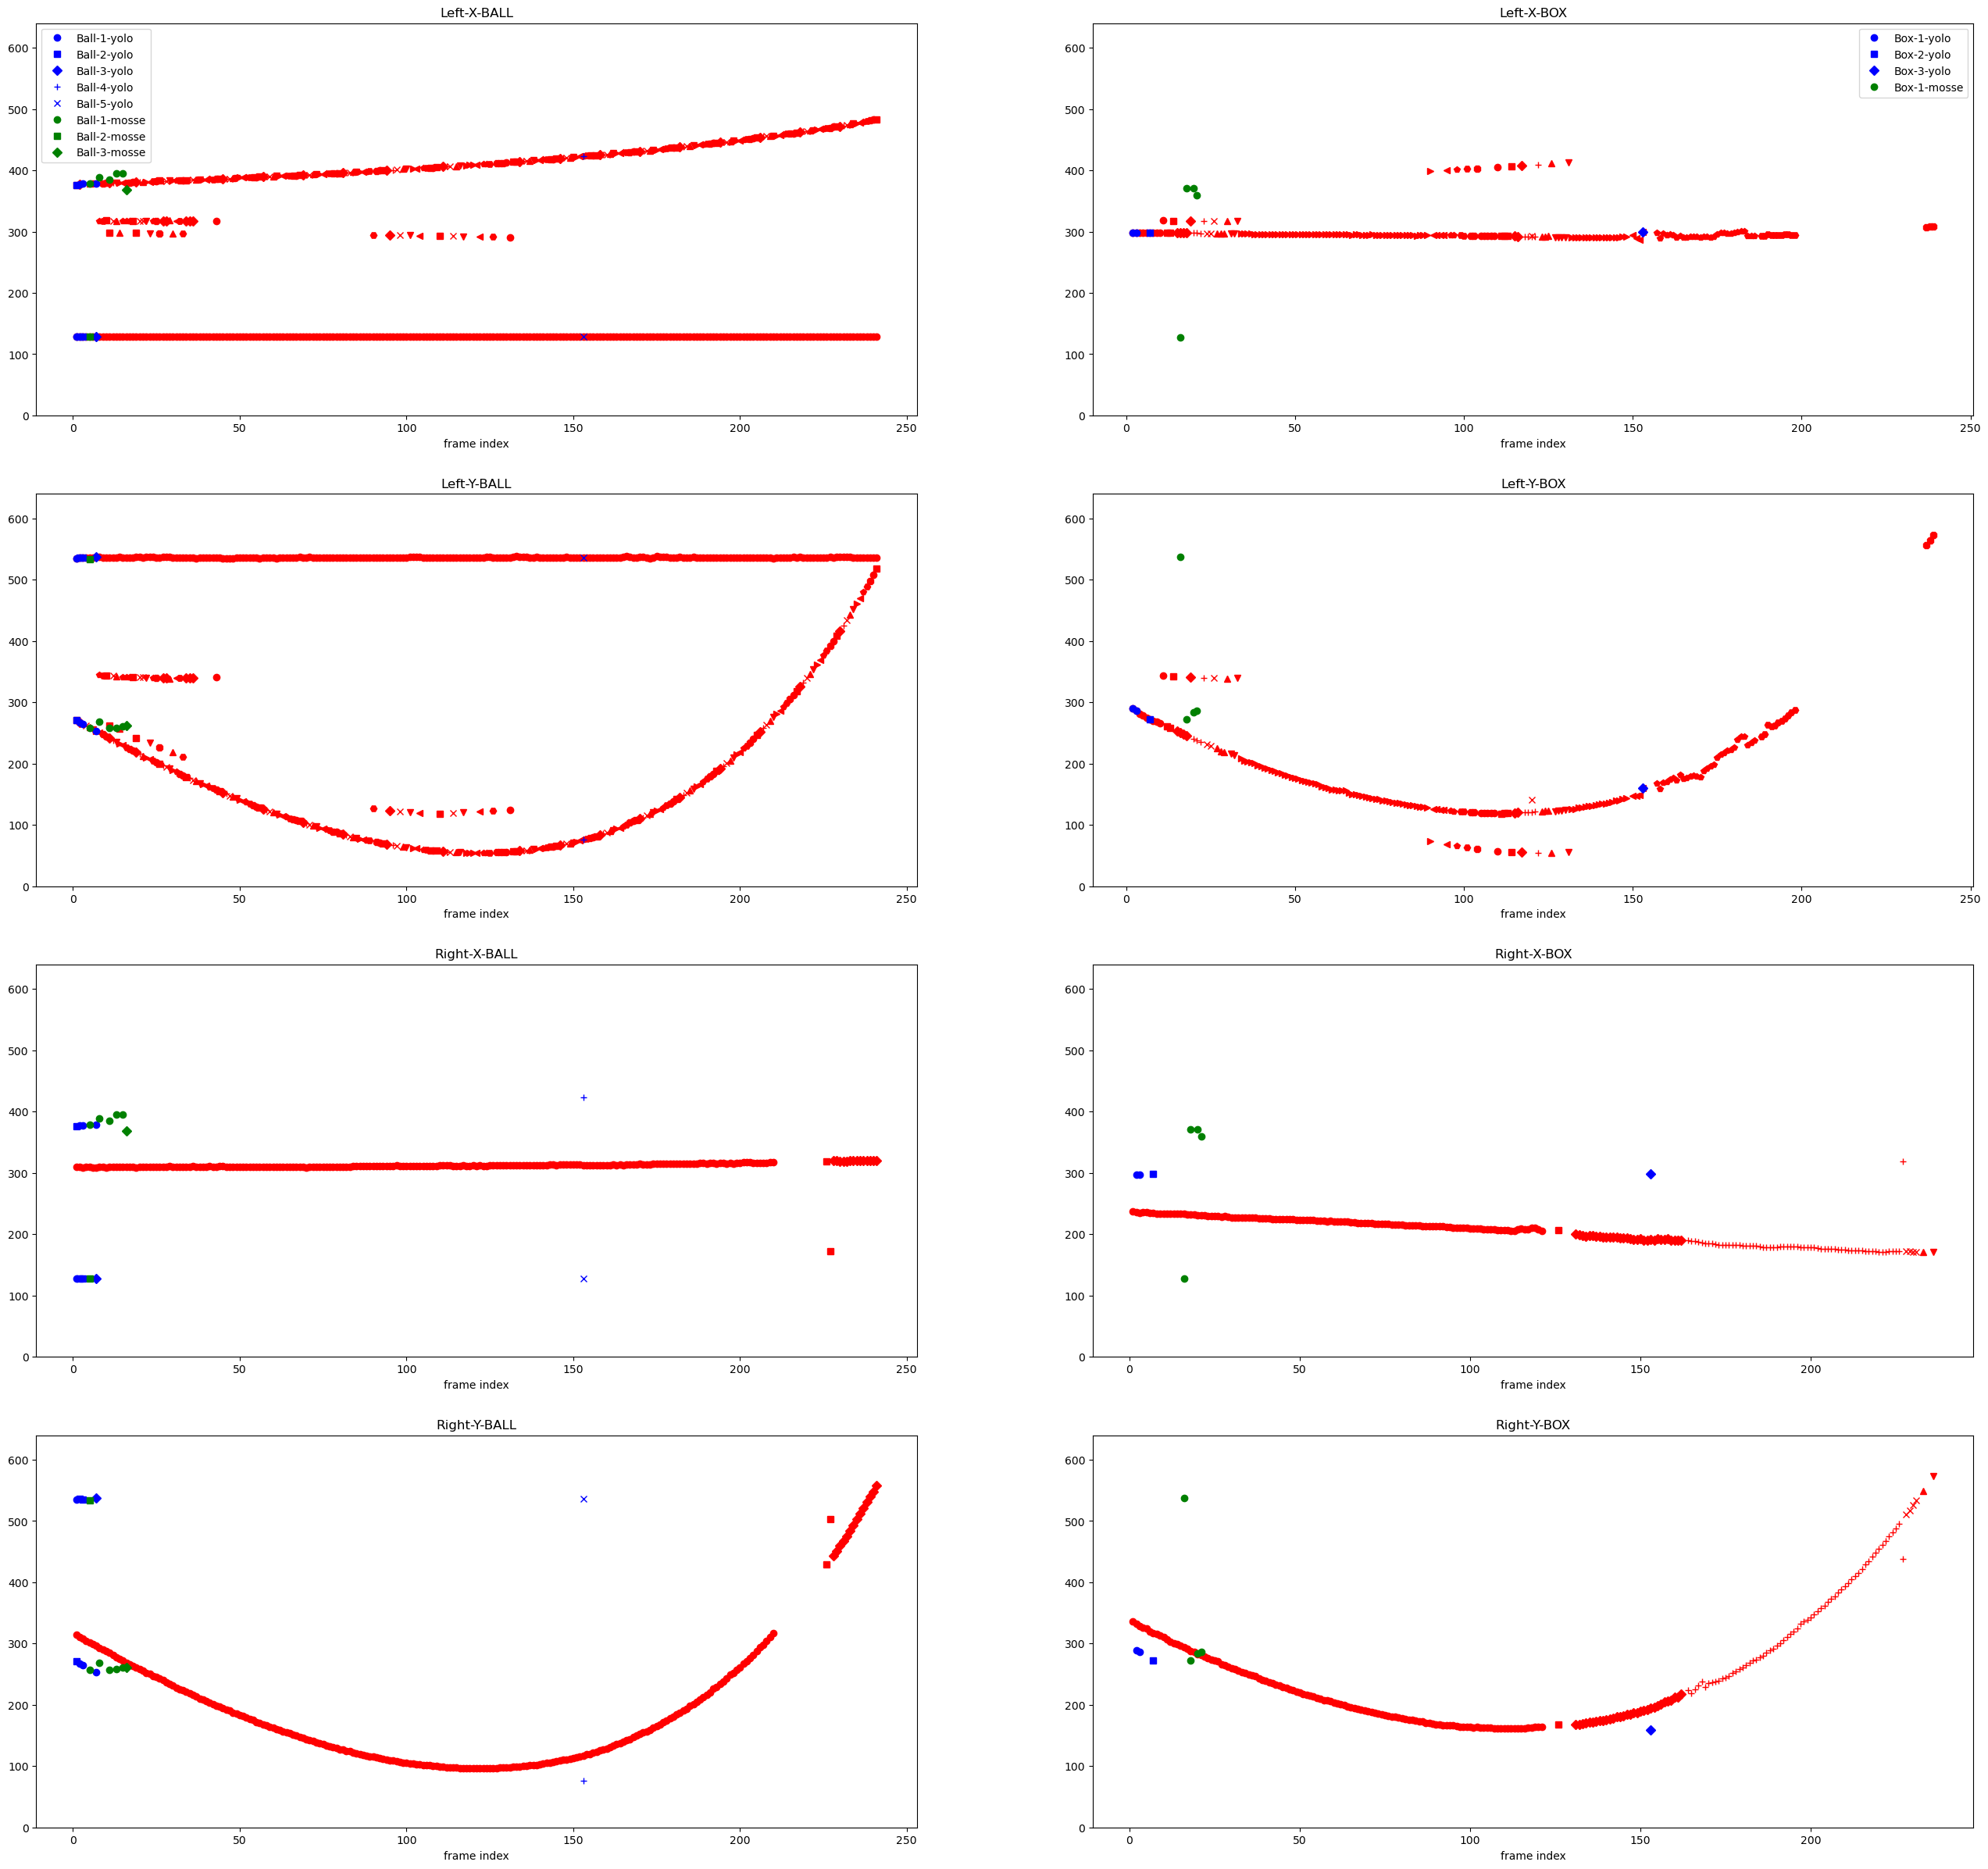

In [15]:
poss = ["Left","Right"]
types = ["BALL","BOX"]
axes = ["X","Y"]
titles = []
for pos in poss:
    for axis in axes:
        for type in types:
            titles.append(pos+"-"+axis+"-"+type)
fig,ax = plt.subplots(4,2,figsize=(32,30))
plotData(data=dict_gt_left,color="r",data_name="rawData",pos="left",fig=fig,ax=ax)
plotData(data=dict_gt_right,color="r",data_name="rawData",pos="right",fig=fig,ax=ax)
plotData(data=dict_yolo_left,color="b",data_name="yolo",pos="left",fig=fig,ax=ax)
plotData(data=dict_yolo_left,color="b",data_name="yolo",pos="right",fig=fig,ax=ax)
plotData(data=dict_mosse_left,color="g",data_name="mosse",pos="left",fig=fig,ax=ax)
plotData(data=dict_mosse_left,color="g",data_name="mosse",pos="right",fig=fig,ax=ax)
for i in range(4): #y
    for j in range(2): #x
        if i== 0:
            ax[i][j].legend()
        ax[i][j].set_ylim(0,640)
        ax[i][j].set_title(titles[i*2+j])
        ax[i][j].set_xlabel("frame index")
plt.show()

## Evaluate Tracking
- RMSE :: calculate RMSE for each Tracker and adapt minimum RMSE
- IoU :: To do

## RMSE

In [29]:
print(dict_gt_left['Ball-1'][0][1:5])

[105.0, 509.0, 46.0, 52.0]


In [30]:
def rmse(x0,y0,x1,y1):
    return ((x0-x1)**2+(y0-y1)**2)**(1/2)

def iou(data1,data2):
    """calculate IoU (intersection over union)

    Args:
        data1 (list): real-time data ([left, top, width, height])
        data2 (_type_): ground truth data
    """
    left_1 = data1[0]
    top_1 = data1[1]
    right_1 = left_1 + data1[2]
    bottom_1 = top_1 + data1[3]
    left_2 = data2[0]
    top_2 = data2[1]
    right_2 = left_2 + data2[2]
    bottom_2 = top_2 + data2[3]
    left_i = max(left_1,right_1)
    top_i = max(top_1,top_2)
    right_i = min(right_1,right_2)
    bottom_i = min(bottom_1,bottom_2)
    if ((right_i - left_i)>0 and (bottom_i - top_i)>0):
        intersection = (right_i-left_i)*(bottom_i-top_i)
        union = (right_1-left_1)*(bottom_1-top_1) + (right_2-left_2)*(bottom_2-top_2) - intersection
        iou = intersection/union
        return iou
    else:
        return 0.0

In [51]:
def evaluation(data,data30):
    """calculate RMSE and sequence data for each label-> available for only 2 objects evaluation

    Args:
        data (dict): Ground truth
        data30 (dict): compared data
    Return:
        rmseBall,rmseBox,iouBall,iouBox,sequenceBall,sequenceBox (dict) : rmse, IoU and sequential data
    """
    #prepare dictionary for saving data
    rmseBall = dict() #[frameIndex,rmse]
    rmseBox = dict()
    sequenceBall=dict()
    sequenceBox = dict()
    iouBall = dict() #[frameIndex,iou]
    iouBox = dict()
    boolSaveBall = False #check if saved
    boolSaveBox = False
    #Ground Truth
    for keyGT in data:
        #print("Ground truth = ",keyGT)
        labelGT = keyGT.split("-")[0] #label : ball or box
        tempDataGT = data[keyGT]
        tempFrameGT = []
        tempPositionXGT = []
        tempPositionYGT = []
        tempBboxGT = []
        for i in range(len(tempDataGT)):
            tempFrameGT.append(tempDataGT[i][0]) #frameIndex
            tempBboxGT.append(tempDataGT[i][1:]) #[left,top,width,height]
            centerX = tempDataGT[i][1]+tempDataGT[i][3]/2
            centerY = tempDataGT[i][2]+tempDataGT[i][4]/2
            tempPositionXGT.append(centerX)
            tempPositionYGT.append(centerY)
        tempFrameGT = np.array(tempFrameGT)
        tempBboxGT = np.array(tempBboxGT)
        tempPositionXGT = np.array(tempPositionXGT)
        tempPositionYGT = np.array(tempPositionYGT)
        #30 fps
        boolBallFirst = False #for saving ball tracking data only once
        boolBoxFirst = False
        for key in data30: #real-time data
            #print("compared with ",key)
            label = key.split("-")[0] #label : ball or box
            if label==labelGT: #2 labels match -> calculate RMSE if frame is same
                tempData = data30[key]
                #print(tempData)
                for i in range(len(tempData)):
                    if (i<len(tempData)-1):
                        frame = tempData[i+1][0]
                    else:
                        frame = tempData[i][0]+1
                    centerX = tempData[i][1]+tempData[i][3]/2
                    centerY = tempData[i][2]+tempData[i][4]/2
                    tempBbox = tempData[i][1:]
                    if frame in tempFrameGT: #there is a matched frame -> calculate RMSE and IoU
                        [index] = np.where(tempFrameGT==frame)[0]
                        #print("index=",index)
                        centerXGT = tempPositionXGT[index]
                        centerYGT = tempPositionYGT[index]
                        RMSE = rmse(centerXGT,centerYGT,centerX,centerY)
                        #print(tempBbox,tempBboxGT[index])
                        IoU = iou(tempBbox,tempBboxGT[index])
                        #print(IoU)
                        if label == "Ball":
                            #print("Ball")
                            #rmse data
                            if not frame in rmseBall: #no RMSE
                                rmseBall[frame] = [RMSE]
                            else: #already have RMSE
                                rmseBall[frame].append(RMSE)
                            #iou data
                            if not frame in iouBall: #no RMSE
                                iouBall[frame] = [IoU]
                            else: #already have RMSE
                                iouBall[frame].append(IoU)
                        elif label == "Box":
                            #print("Box")
                            #rmse data
                            if not frame in rmseBox: #no RMSE
                                rmseBox[frame] = [RMSE]
                            else: #already have RMSE
                                rmseBox[frame].append(RMSE)
                            #iou data
                            if not frame in iouBox: #no RMSE
                                iouBox[frame] = [IoU]
                            else: #already have RMSE
                                iouBox[frame].append(IoU)
                    if label=="Ball" and not boolSaveBall:
                        boolBallFirst = True
                        #sequence data
                        if not frame in sequenceBall: #no RMSE
                            sequenceBall[frame] = [[centerX,centerY]]
                        else: #already have RMSE
                            sequenceBall[frame].append([centerX,centerY])
                    if label=="Box" and not boolSaveBox:
                        boolBoxFirst=True
                        #sequence data
                        if not frame in sequenceBox: #no RMSE
                            sequenceBox[frame] = [[centerX,centerY]]
                        else: #already have RMSE
                            sequenceBox[frame].append([centerX,centerY])     
            else: #other label
                continue
        if boolBallFirst:
            boolSaveBall=True
        if boolBoxFirst:
            boolSaveBox=True
    return rmseBall,rmseBox,iouBall,iouBox,sequenceBall,sequenceBox

In [52]:
rmseBall_mosse_left,rmseBox_mosse_left,iouBall_mosse_left,iouBox_mosse_left,sequenceBall_mosse_left,sequenceBox_mosse_left = evaluation(data=dict_gt_left,data30=dict_mosse_left)
rmseBall_mosse_right,rmseBox_mosse_right,iouBall_mosse_right,iouBox_mosse_right,sequenceBall_mosse_right,sequenceBox_mosse_right = evaluation(data=dict_gt_right,data30=dict_mosse_right)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


## get minimal value and plot

In [37]:
def rmseExtraction(rmseBall30):
    """return minimum RMSE 

    Args:
        rmseBall30 (dict): sequence rmse data

    Returns:
        aveRMSE(float),RMSE_BALL30(array): rmse data 
    """
    RMSE_BALL30 = []
    for key in rmseBall30:
        if (len(rmseBall30[key])>=2):
            RMSE = min(rmseBall30[key])
        else:
            RMSE = rmseBall30[key][0]
        RMSE_BALL30.append([key,RMSE])
    RMSE_BALL30 = np.array(RMSE_BALL30)
    #sort data with 1st columns value
    sorted_indices = np.argsort(RMSE_BALL30[:,0])
    RMSE_BALL30 =RMSE_BALL30[sorted_indices]
    aveRMSE = round(RMSE_BALL30[:,1].mean(),2)
    print(f"average RMSE = {aveRMSE}")
    return aveRMSE,RMSE_BALL30

def iouExtraction(iouBall30):
    """return max IoU

    Args:
        rmseBall30 (dict): sequence IoU data

    Returns:
        aveIoU(float),iou_BALL30(array): iou data 
    """
    iou_BALL30 = []
    for key in iouBall30:
        if (len(iouBall30[key])>=2):
            iou = max(iouBall30[key])
        else:
            iou = iouBall30[key][0]
        iou_BALL30.append([key,iou])
    iou_BALL30 = np.array(iou_BALL30)
    #sort data with 1st columns value
    sorted_indices = np.argsort(iou_BALL30[:,0])
    iou_BALL30 =iou_BALL30[sorted_indices]
    aveiou = round(iou_BALL30[:,1].mean(),2)
    print(f"average IoU = {aveiou}")
    return aveiou,iou_BALL30

In [38]:
aveRMSE_ball_mosse_left, rmse_ball_mosse_left = rmseExtraction(rmseBall30=rmseBall_mosse_left)
aveRMSE_box_mosse_right, rmse_box_mosse_right = rmseExtraction(rmseBall30=rmseBox_mosse_right)
aveIoU_ball_mosse_left, iou_ball_mosse_left = iouExtraction(iouBall30=iouBall_mosse_left)
aveIoU_box_mosse_right, iou_box_mosse_right = iouExtraction(iouBall30=iouBox_mosse_right)

average RMSE = 24.32
average RMSE = 36.56
average RMSE = 0.0
average RMSE = 0.0


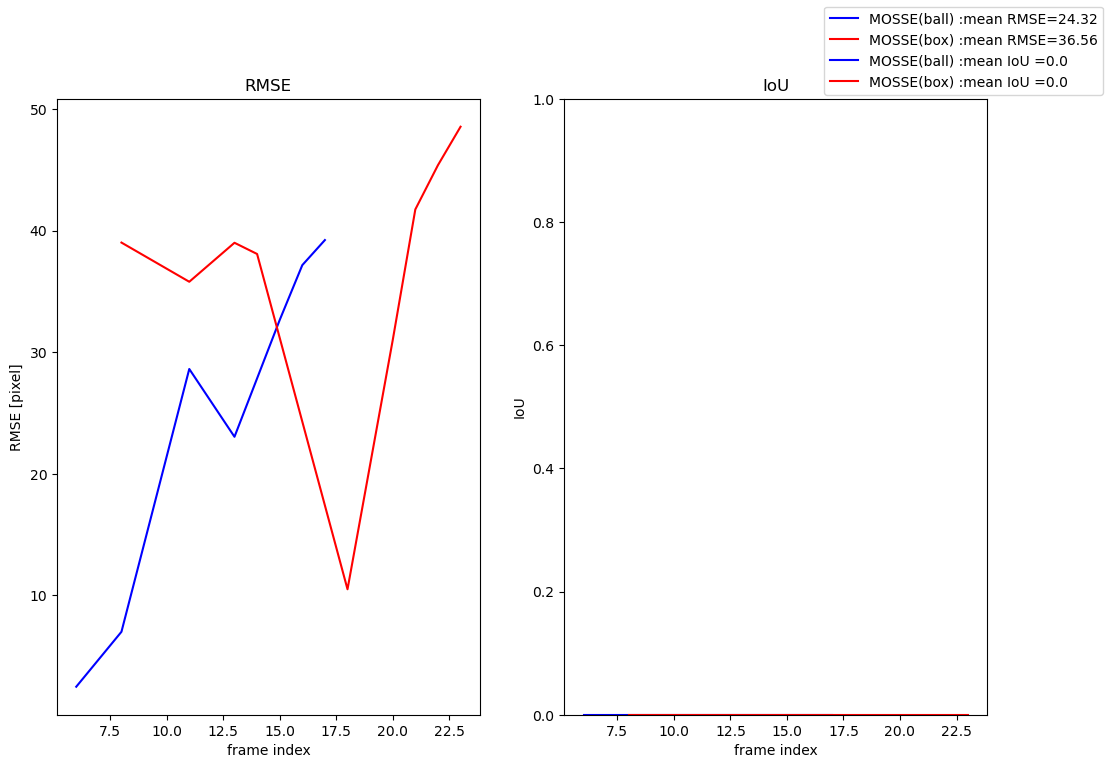

In [54]:
fig,ax = plt.subplots(1,2,figsize=(12,8))
ax[0].plot(rmse_ball_mosse_left[:,0],rmse_ball_mosse_left[:,1],color="b",linestyle="-",label=f"MOSSE(ball) :mean RMSE={aveRMSE_ball_mosse_left}")
ax[0].plot(rmse_box_mosse_right[:,0],rmse_box_mosse_right[:,1],color="r",linestyle="-",label=f"MOSSE(box) :mean RMSE={aveRMSE_box_mosse_right}")
ax[0].set_xlabel("frame index")
ax[0].set_ylabel("RMSE [pixel]")
ax[0].set_title("RMSE")
ax[1].plot(iou_ball_mosse_left[:,0],iou_ball_mosse_left[:,1],color="b",linestyle="-",label=f"MOSSE(ball) :mean IoU ={aveIoU_ball_mosse_left}")
ax[1].plot(iou_box_mosse_right[:,0],iou_box_mosse_right[:,1],color="r",linestyle="-",label=f"MOSSE(box) :mean IoU ={aveIoU_box_mosse_right}")
ax[1].set_xlabel("frame index")
ax[1].set_ylabel("IoU")
ax[1].set_title("IoU")
ax[1].set_ylim(0,1)
fig.legend()
plt.show()

# Make Movie

In [41]:
import glob
import cv2
import os
import re

def drawRectangle(data,colorBall,colorBox,src,saveDir,boolgroundTruth=False):
    """draw rectangle in images

    Args:
        data (dict): sequence data of each tracker
        colorBall,colorBox(list) : rectangle color
        boolgroundTruth (bool) : if ground truth or not
        src (_type_, optional): path to source directory
        saveDir (_type_, optional): path to save directory
    """
    # Use glob to find all image files in the directory
    image_files = glob.glob(os.path.join(src, '*.png'))
    #draw rectangle
    frame_count = 0
    numBall = 1
    numBox = 1
    numKey = 0
    for key in data:
        label = key.split("-")[0] #label : ball or box
        tempData = data[key]
        tempFrame = []
        for i in range(len(tempData)):
            if boolgroundTruth:
                tempFrame.append(tempData[i][0])
            else:
                if (i<len(tempData)-1):
                    tempFrame.append(tempData[i+1][0])
                else:
                    tempFrame.append(tempData[i][0]+1)
        if (label=="Ball"):
            numBall += 1
        elif (label=="Box"):
            numBox += 1
        
        counter=0
        counterFrame = 0
        # Print the list of image files
        if numKey == 0:
            for image_file in image_files:
                print(f"counter:{counter+1}")
                frame = cv2.imread(image_file)
                if (label=="Ball"):
                    if (counter+1) in tempFrame:
                        cv2.rectangle(frame,(int(tempData[counterFrame][1]),int(tempData[counterFrame][2])),(int(tempData[counterFrame][1]+tempData[counterFrame][3]),int(tempData[counterFrame][2]+tempData[counterFrame][4])),
                                        color=colorBall,thickness=2) #[0,0,abs(255-numBall*20)%255]
                        counterFrame += 1
                else: #Box
                    if (counter+1) in tempFrame:
                        cv2.rectangle(frame,(int(tempData[counterFrame][1]),int(tempData[counterFrame][2])),(int(tempData[counterFrame][1]+tempData[counterFrame][3]),int(tempData[counterFrame][2]+tempData[counterFrame][4])),
                                        color=colorBox,thickness=2) #[abs(255-numBox*20),0,0]
                        counterFrame += 1
                cv2.imwrite(os.path.join(saveDir,f"{(counter+1):03d}.png"),frame)
                counter+=1
        else:
            image_files = glob.glob(os.path.join(saveDir, '*.png'))
            for image_file in image_files:
                print(f"counter:{counter+1}")
                frame = cv2.imread(image_file)
                if (label=="Ball"):
                    if (counter+1) in tempFrame:
                        cv2.rectangle(frame,(int(tempData[counterFrame][1]),int(tempData[counterFrame][2])),(int(tempData[counterFrame][1]+tempData[counterFrame][3]),int(tempData[counterFrame][2]+tempData[counterFrame][4])),
                                        color=colorBall,thickness=2) #[0,0,abs(255-numBall*60)%255]
                        counterFrame += 1
                else: #Box
                    if (counter+1) in tempFrame:
                        cv2.rectangle(frame,(int(tempData[counterFrame][1]),int(tempData[counterFrame][2])),(int(tempData[counterFrame][1]+tempData[counterFrame][3]),int(tempData[counterFrame][2]+tempData[counterFrame][4])),
                                        color=colorBox,thickness=2) #[0,0,abs(255-numBall*60)%255]
                        counterFrame += 1
                cv2.imwrite(os.path.join(saveDir,f"{(counter+1):03d}.png"),frame)
                counter+=1
        numKey += 1

In [42]:
src_left = r'C:\Users\kawaw\master\Catching\evaluation\video\objectTracking\2objects_close_left'
src_right = r'C:\Users\kawaw\master\Catching\evaluation\video\objectTracking\2objects_close_right'
saveDir_left = os.path.join(src_left,"real-time")
saveDir_right = os.path.join(src_right,"real-time")
if not os.path.exists(saveDir_left):
    os.makedirs(saveDir_left)
if not os.path.exists(saveDir_right):
    os.makedirs(saveDir_right)

drawRectangle(data=dict_mosse_left,colorBall=[255,0,0],colorBox=[0,0,255],src=src_left,saveDir=saveDir_left,boolgroundTruth=False)
drawRectangle(data=dict_mosse_right,colorBall=[255,0,0],colorBox=[0,0,255],src=src_right,saveDir=saveDir_right,boolgroundTruth=False)

counter:1
counter:2
counter:3
counter:4
counter:5
counter:6
counter:7
counter:8
counter:9
counter:10
counter:11
counter:12
counter:13
counter:14
counter:15
counter:16
counter:17
counter:18
counter:19
counter:20
counter:21
counter:22
counter:23
counter:24
counter:25
counter:26
counter:27
counter:28
counter:29
counter:30
counter:31
counter:32
counter:33
counter:34
counter:35
counter:36
counter:37
counter:38
counter:39
counter:40
counter:41
counter:42
counter:43
counter:44
counter:45
counter:46
counter:47
counter:48
counter:49
counter:50
counter:51
counter:52
counter:53
counter:54
counter:55
counter:56
counter:57
counter:58
counter:59
counter:60
counter:61
counter:62
counter:63
counter:64
counter:65
counter:66
counter:67
counter:68
counter:69
counter:70
counter:71
counter:72
counter:73
counter:74
counter:75
counter:76
counter:77
counter:78
counter:79
counter:80
counter:81
counter:82
counter:83
counter:84
counter:85
counter:86
counter:87
counter:88
counter:89
counter:90
counter:91
counter:

# Make movie from images

In [43]:
import glob

import cv2
import os
import re

class MakeVideo():
    def __init__(self,imgsize,src,videoname):
        self.imgsize = imgsize
        self.src = src
        self.videoname = videoname
        self.main()

    def atoi(self,text):
        return int(text) if text.isdigit() else text

    def natural_keys(self,text):
        return [ self.atoi(c) for c in re.split(r'(\d+)', text) ]

    def main(self):
        img_array=[]
        for filename in sorted(glob.glob(f"{self.src}/*.png"), key=self.natural_keys):
            img = cv2.imread(filename)
            height, width, layers = img.shape
            size = (width, height)
            img_array.append(img)

        out = cv2.VideoWriter(self.videoname, cv2.VideoWriter_fourcc(*'mp4v'), 20.0, self.imgsize)

        for i in range(len(img_array)):
            out.write(img_array[i])
        out.release()

In [44]:
src_left = r"C:\Users\kawaw\master\Catching\evaluation\video\objectTracking\2objects_close_left\real-time"
src_right = r"C:\Users\kawaw\master\Catching\evaluation\video\objectTracking\2objects_close_right\real-time"
videoname_left = r"C:\Users\kawaw\master\Catching\evaluation\video\objectTracking\2objects_close_left_realtime.mp4"
videoname_right = r"C:\Users\kawaw\master\Catching\evaluation\video\objectTracking\2objects_close_right_realtime.mp4"
imgsize = (640,640)
mkVideo_left = MakeVideo(imgsize=imgsize,src=src_left,videoname=videoname_left)
mkVideo_right = MakeVideo(imgsize=imgsize,src=src_right,videoname=videoname_right)

# Count Tracker labels

In [81]:
def checkLabelNumber(dataClass)-> list:
    """check label number

    Args:
        dataClass (array): sequential class label
    Return:
        data(list): [[frameIndex,total label, ball, box, lost],
    """
    numTime = dataClass.shape[0] # number of sequential time steps
    print(numTime)
    numData = dataClass.shape[1]//2 # number of data
    data = [] #list for saving sequence data
    for i in range(numTime):
        booStart=False
        numTotal=0
        numBall = 0
        numBox = 0
        numLost = 0
        for j in range(numData):
            if dataClass[i][j*2+1] == -2: #data change from positive to negative
                break
            if dataClass[i][j*2+1] == 0:
                numBall += 1
            elif dataClass[i][j*2+1] == 1:
                numBox += 1
            elif dataClass[i][j*2+1] == -1:
                numLost+=1
            numTotal += 1
        data.append([dataClass[i][0],numTotal,numBall,numBox,numLost])
    return np.array(data)



In [82]:
labels_left = checkLabelNumber(dataClass=class_gt_left)
print(labels_left.shape)
labels_mosse_left =checkLabelNumber(dataClass=class_mosse_left)
print(labels_mosse_left.shape)
labels_right = checkLabelNumber(dataClass=class_gt_right)
print(labels_right.shape)
labels_mosse_right =checkLabelNumber(dataClass=class_mosse_right)
print(labels_mosse_right.shape)
#labels100 = checkLabelNumber(dataClass=dataClass100)
#print(labels100.shape)

241
(241, 5)
55
(55, 5)
241
(241, 5)
55
(55, 5)


## Plot data

In [83]:
markers=['o','s','D','+','x','^','v','>','<','p','H','8']
markers=np.array(markers)
lines = [" ","--"]
colors=["r","g","b","c","m","y","k","w"]

In [95]:
def plotData(labels,colors,fig_loc,title,ax,boolLabel=False,markers=markers[:4]):
    frame = labels[:,0]
    numTotal = labels[:,1]
    numBall = labels[:,2]
    numBox = labels[:,3]
    numLost = labels[:,4]
    legends = ["total","ball","box","lost"]
    for i in range(4):
        if boolLabel:
            ax[fig_loc[0],fig_loc[1]].plot(frame,labels[:,(i+1)],color=colors[i],marker=markers[i],label=legends[i])
        else:
            ax[fig_loc[0],fig_loc[1]].plot(frame,labels[:,(i+1)],color=colors[i],marker=markers[i])
        ax[fig_loc[0],fig_loc[1]].set_title(title)
        if fig_loc[0] == 0:
            ax[fig_loc[0],fig_loc[1]].set_ylim(0,300)
        elif fig_loc[0] == 1:
            ax[fig_loc[0],fig_loc[1]].set_ylim(0,10)

### ground truth

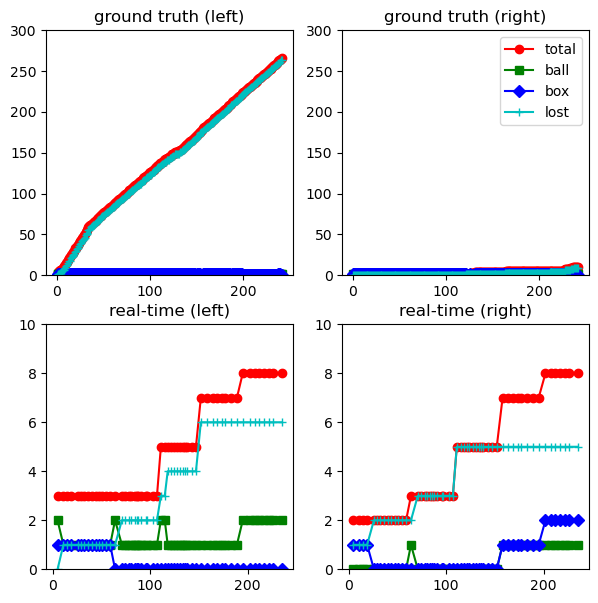

In [96]:
LABEL=True
titles = ["ground truth (left)","ground truth (right)","real-time (left)","real-time (right)"]
fig,ax = plt.subplots(2,2,figsize=(7,7))
plotData(labels=labels_left,colors=colors,title=titles[0],fig_loc=(0,0),ax=ax,boolLabel=LABEL)
plotData(labels=labels_right,colors=colors,title=titles[1],fig_loc=(0,1),ax=ax,boolLabel=LABEL)
plotData(labels=labels_mosse_left,colors=colors,title=titles[2],fig_loc=(1,0),ax=ax,boolLabel=LABEL)
plotData(labels=labels_mosse_right,colors=colors,title=titles[3],fig_loc=(1,1),ax=ax,boolLabel=LABEL)
if LABEL:
    ax[0,1].legend()
plt.show()